<a href="https://colab.research.google.com/github/lauraliron/ufv_visualizacion/blob/main/Ejercicios%20Clase/PracticaClase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En esta práctica, nuestro objetivo es analizar y evaluar la distribución y precisión de las predicciones de ventas para distintas bebidas en diferentes países. Utilizando un dataset con datos de ventas reales y pronósticos.

###Instalación de librerias y carga de datos

Lo primero que haremos es instalar todas las librerias necesarias.


In [74]:
pip install plotly_express

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

###Análisis de datos


Una vez cargado el archivo CSV, realizamos una exploración inicial para obtener una vista rápida de los datos, lo cual nos permite comprender el contenido y las primeras cinco filas de nuestro conjunto de datos.
El objetivo de esta vista inicial es identificar las columnas que contiene el dataset y observar los tipos de datos de cada columna.

In [76]:
df = pd.read_csv('datos_ejercicio_ventas.csv')
df.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,754356.237194
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023.0,560030.558029
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847
3,Great Britain,7up (L3),2024,12,AI_forecast,AI_P10F,2023.0,363224.511516
4,Hungary,Lipton (L3),2023,9,AI_forecast,AI_P03F,2023.0,396176.120491


Al no comprender del todo la variable scenario ya que sale siempre el mismo valor, vamos a ver los tipos que pueden darse.

In [77]:
valores_unicos_scenario = df['SCENARIO'].unique()
print("Valores únicos en SCENARIO:", valores_unicos_scenario)

Valores únicos en SCENARIO: ['AI_forecast' 'actual']


Es decir, que la variable 'SCENARIO' hablara de valores predichos y valores actuales o reales.

Una vez conocemos la informacion que contiene el conjunto de datos sobre las ventas realizadas y las previsiones de ventas explicaremso las variables para tenerlas claras durante todo el proceso de análisis.

**COUNTRY**: Representa el país en el que se realiza una predicción de venta.

**SUBBRAND**: Hace referencia a diferentes marcas de bebidas.

**YEAR**: Indica el año en el que se registra la previsión.

**MONTH**: Señala el mes en el que se registra la previsión.

**SCENARIO**: Describe el tipo de dato representado en la fila, como "AI_forecast" (previsión) o "actual" (ventas reales).

**FORECAST**: Muestra el valor de previsión de ventas, es decir, la cantidad estimada para ese país, sub-marca, año y mes. Esta columna es clave para analizar qué tan precisas fueron las previsiones en comparación con las ventas reales.

**FORECAST_YEAR**: Indica el año en que se realizó la previsión. Por ejemplo, si en 2022 se hizo una previsión para el 2023, FORECAST_YEAR sería 2022 y YEAR sería 2023.

**AMOUNT**: Valor numérico de la previsión de ventas para el país, sub-marca, año y mes especificados.


Una de las primeras tareas al explorar un conjunto de datos es saber cuántas filas y columnas contiene, ya que esto nos da una idea de la escala y nos ayuda a planificar el análisis. En este caso, vamos a calcular y mostrar el número de filas.

In [78]:
num_filas = df.shape[0]
print(f"El número de filas es {num_filas}")

El número de filas es 18666


Acontinuación, analizaremos la cantidad de valores NaN en cada columna.


In [79]:
nan_count = df.isna().sum()
print(nan_count)

COUNTRY            0
SUBBRAND           0
YEAR               0
MONTH              0
SCENARIO           0
FORECAST         900
FORECAST_YEAR    900
AMOUNT             0
dtype: int64


Es posible que los registros con NaN en FORECAST y FORECAST_YEAR representen ventas reales (actuals), en cuyo caso, podría tener sentido conservar estas filas para otro tipo de análisis, como estudiar los resultados reales por sí mismos. Por ello, no los eliminaremos hasta comprobarlo.

Estudiaremos los SCENARIO cuando se encuentran Nans en FORECAST y FORECAST_YEAR para decidir si eliminar estos valores definitivamente.

In [80]:
scenario_con_nan = df[df['FORECAST'].isna() | df['FORECAST_YEAR'].isna()]['SCENARIO']
print("Valores de SCENARIO cuando hay NaN en FORECAST o FORECAST_YEAR:")
print(scenario_con_nan.unique())

Valores de SCENARIO cuando hay NaN en FORECAST o FORECAST_YEAR:
['actual']


Al estar en SCENARIO 'actual' no los eliminaremos pero nos aseguramos comprobando que hay la misma cantidad de Nan que de 'actual'.

In [81]:
conteo_escenarios = df['SCENARIO'].value_counts()

print(conteo_escenarios)

SCENARIO
AI_forecast    17766
actual           900
Name: count, dtype: int64


Habiendo la misma cantidad de Nan que de 'actual' nos hemos asegurado de que no debemos eliminarlos ya que son escenarios que aun no han pasado.

Vemos con cuántos paises y cuáles son con los que contamos en la base de datos.

In [82]:
num_paises = df['COUNTRY'].nunique()

lista_paises = df['COUNTRY'].unique()

print(f"El número de países es: {num_paises}")
print("Los países son:", lista_paises)


El número de países es: 9
Los países son: ['Portugal' 'Great Britain' 'Spain' 'Hungary' 'Norway' 'Denmark'
 'Netherlands' 'Italy' 'Czech']


Agrupamos por paises y obtenemos el conjunto de bebidas que hay en cada país para ver si tienen las mismas marcas

In [83]:
bebidas_por_pais = df.groupby('COUNTRY')['SUBBRAND'].apply(set)

todas_las_bebidas = set(df['SUBBRAND'].unique())

mismo_bebidas = bebidas_por_pais.apply(lambda x: x == todas_las_bebidas)

if mismo_bebidas.all():
    print("Todos los países tienen las mismas bebidas.")
else:
    print("No todos los países tienen las mismas bebidas.")

No todos los países tienen las mismas bebidas.


###Cómo se distribuyen las ventas

Analizar cómo se distribuyen las ventas en cada país es fundamental en un análisis de ventas. Ya que puede ayudarnos a identificar cuáles son los países con mayor volumen de ventas y, por lo tanto, mercados clave para el negocio.

Vamos a tratar de realizar un mapa de calor sobre el mapa de Europa para comprobar qué paises tienen mayores ventas. Para ello, lo primero que debemos hacer es un idccionario de códigos ISO Alpha-3 que se basa en un estándar internacional de códigos de tres letras que identifica cada país en el mundo.

In [84]:
iso_codes = {
    'Czech': 'CZE',
    'Denmark': 'DNK',
    'Great Britain': 'GBR',
    'Hungary': 'HUN',
    'Italy': 'ITA',
    'Netherlands': 'NLD',
    'Norway': 'NOR',
    'Portugal': 'PRT',
    'Spain': 'ESP'
}

Una vez tenemos los ISO Alpha-3 sumaremos las ventas de cada país y crearemos el maapa de calor.

In [85]:
ventas_por_pais = df.groupby('COUNTRY')['AMOUNT'].sum().reset_index()

ventas_por_pais['ISO3'] = ventas_por_pais['COUNTRY'].map(iso_codes)

fig = px.choropleth(
    ventas_por_pais,
    locations='ISO3',
    color='AMOUNT',
    hover_name='COUNTRY',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='europe'
)

fig.update_layout(title_text="Distribución de Ventas por país")

fig.show()


Podemos comprobar que el país con mayores ventas es 'Great Britain', sin embargo no queda claro a simple vista cuál es el país con menores ventas. Por ello, realizaré un gráfico de barras para tratar de que se vea con mayor claridad.

<ipython-input-86-66d9ce5d0c42>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




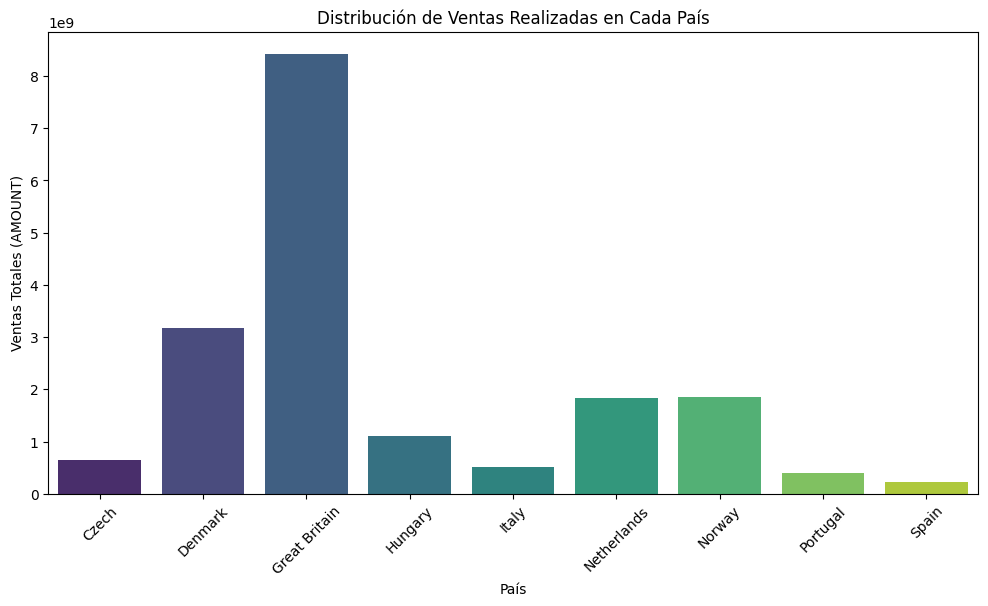

In [86]:
plt.figure(figsize=(12, 6))
sns.barplot(data=ventas_por_pais, x='COUNTRY', y='AMOUNT', palette='viridis')

plt.title("Distribución de Ventas Realizadas en Cada País")
plt.xlabel("País")
plt.ylabel("Ventas Totales (AMOUNT)")
plt.xticks(rotation=45)
plt.show()

De esta forma podemos asegurar que el país con menores ventas previstas es España y confirmar que Great Britain tiene notablemente mayores ventas.

Seguimos estudiando la distibución de las ventas en Portugal dependiendo del mes y el año. Para ello agruparemos por año y mes y sumaremos las ventas posteriormente, haremos un diagrama de línea para poder ver la tendencia de los datos.

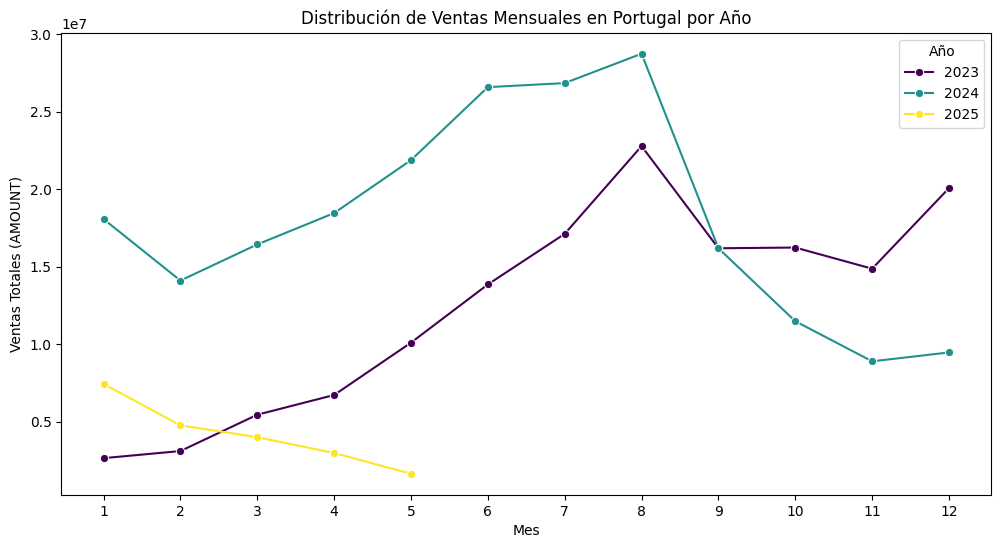

In [87]:
ventas_portugal = df[df['COUNTRY'] == 'Portugal']

ventas_portugal_mes_anio = ventas_portugal.groupby(['YEAR', 'MONTH'])['AMOUNT'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=ventas_portugal_mes_anio, x='MONTH', y='AMOUNT', hue='YEAR', marker='o', palette='viridis')

plt.title("Distribución de Ventas Mensuales en Portugal por Año")
plt.xlabel("Mes")
plt.ylabel("Ventas Totales (AMOUNT)")
plt.xticks(range(1, 13))
plt.legend(title="Año")
plt.show()

El grafico nos muestra como las ventas en 2023 muestran un crecimiento progresivo hasta agosto, alcanzando su punto más alto en ese mes. A partir de septiembre, las ventas disminuyen notablemente y se mantienen estables en niveles más bajos hasta diciembre. En 2024 se tiene una tendencia de crecimiento marcada desde enero hasta julio, donde se registra el valor máximo del año. A partir de julio, las ventas caen de manera continua hasta noviembre, con un ligero repunte en diciembre.Y por último en 2025, las ventas comienzan en niveles bajos en enero y muestran una ligera disminución hasta mayo, donde se observa el valor más bajo en ventas en comparación con los demás años.

Tanto en 2023 como en 2024, se observa un claro patrón estacional con picos de ventas en los meses de verano, especialmente en junio, julio y agosto. Este patrón sugiere que en Portugal hay una mayor demanda durante estos meses.

Descenso de Ventas en Otoño e Invierno (Septiembre - Diciembre): En ambos años (2023 y 2024), se observa una disminución de las ventas a partir de septiembre, manteniéndose en niveles más bajos en los últimos meses del año. Esto sugiere que las ventas tienden a disminuir al final del año.

Estudiamos la distribuciones de las bebidas por mes. Para ello dividiremos las ventas en dos años 2023 y 2024 para ver si siguen algun patrón. Agrupamos las ventas con mes y marca y crearemos dos gráficos de barras donde podremos ver todas las ventas de cada marca al mes.

<ipython-input-88-6cb51f917981>:9: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


<ipython-input-88-6cb51f917981>:17: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




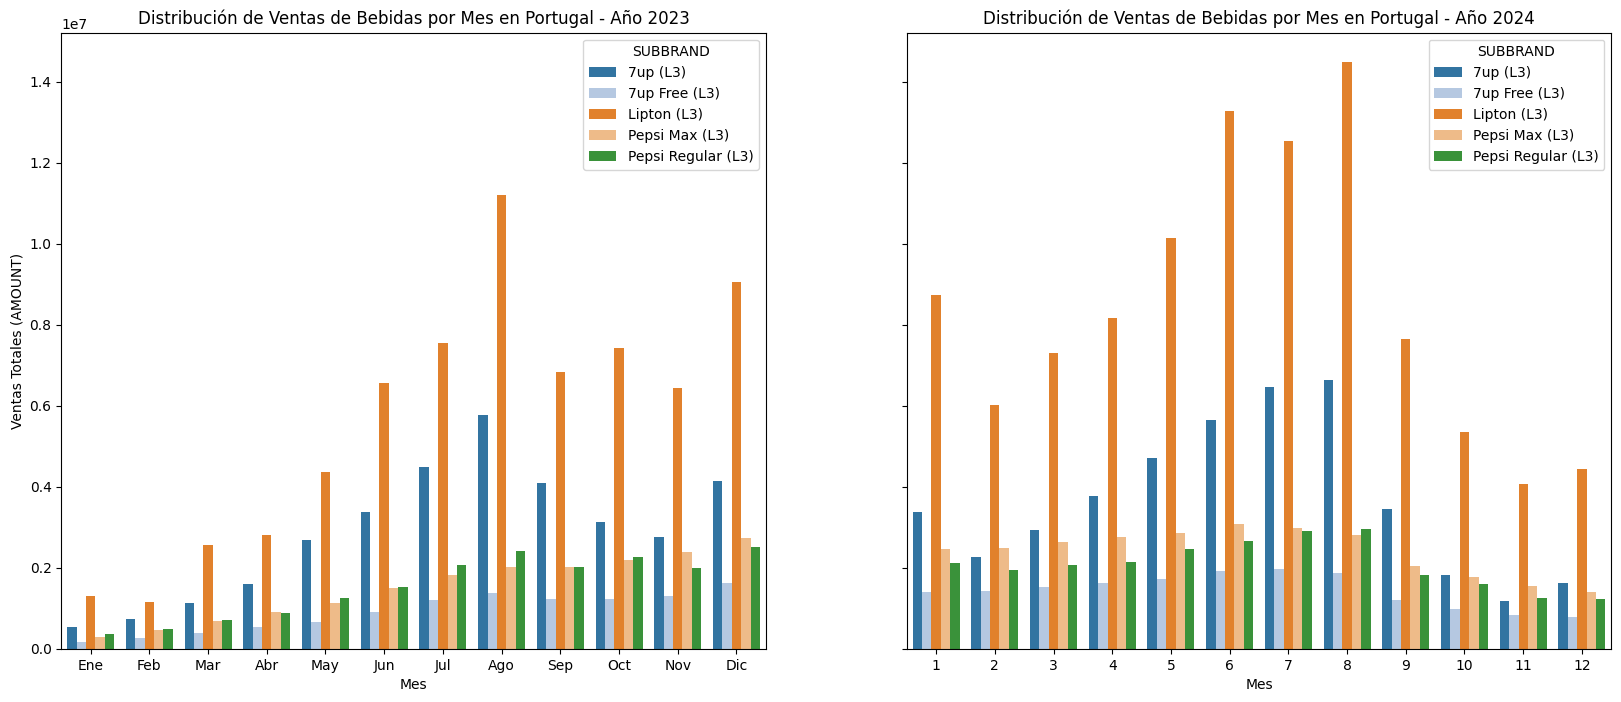

In [88]:
ventas_portugal_bebida_mes_anio = df[df['COUNTRY'] == 'Portugal'].groupby(['YEAR', 'MONTH', 'SUBBRAND'])['AMOUNT'].sum().reset_index()

ventas_portugal_2023 = ventas_portugal_bebida_mes_anio[ventas_portugal_bebida_mes_anio['YEAR'] == 2023]
ventas_portugal_2024 = ventas_portugal_bebida_mes_anio[ventas_portugal_bebida_mes_anio['YEAR'] == 2024]

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)  # `sharey=True` para compartir el eje Y

# Gráfico de 2023
sns.barplot(data=ventas_portugal_2023, x='MONTH', y='AMOUNT', hue='SUBBRAND', ci=None, palette='tab20', ax=axes[0])
axes[0].set_title("Distribución de Ventas de Bebidas por Mes en Portugal - Año 2023")
axes[0].set_xlabel("Mes")
axes[0].set_ylabel("Ventas Totales (AMOUNT)")
axes[0].set_xticks(range(0, 12))
axes[0].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])

# Gráfico de 2024
sns.barplot(data=ventas_portugal_2024, x='MONTH', y='AMOUNT', hue='SUBBRAND', ci=None, palette='tab20', ax=axes[1])
axes[1].set_title("Distribución de Ventas de Bebidas por Mes en Portugal - Año 2024")
axes[1].set_xlabel("Mes")
axes[1].set_ylabel("")


plt.show()


En ambos años, Lipton es consistentemente la bebida más vendida, especialmente en los meses de verano, alcanzando su punto máximo en agosto. Esto indica una preferencia notable por esta bebida en los meses cálidos.

7UP también presenta picos de ventas en verano, aunque generalmente tiene menores ventas comparado con Lipton. 7UP sigue un patrón estacional similar y parece ser la segunda bebida más popular en los meses de verano.

Pepsi Regular y Pepsi Max tienen ventas más estables a lo largo del año y no muestran un pico tan pronunciado en verano, sugiriendo que su consumo es menos estacional.

7UP Free es la bebida con ventas más bajas en comparación con las demás.

Una vez hemos visto la distribución de las ventas dependiendo de los meses y las marcas en 2023 y 2024 haremos un gráfico circular en el que se vea la distribución total de venta de las marcas más vendidas y las que menos.

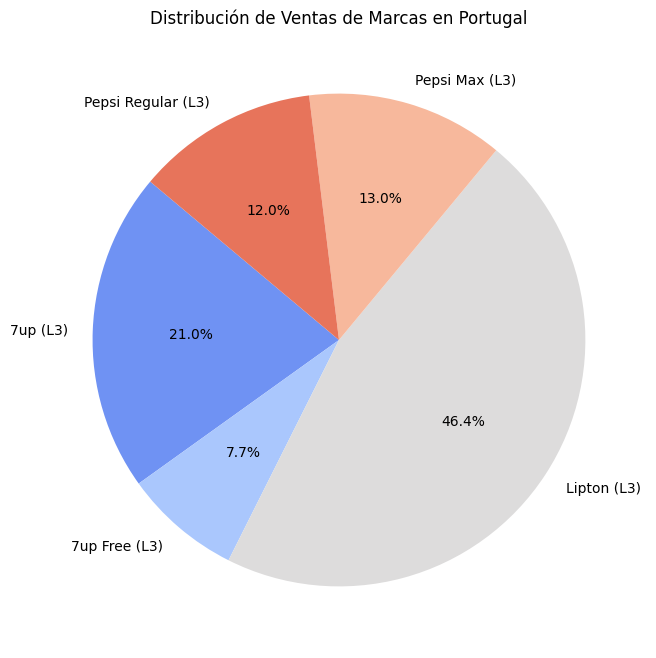

In [89]:
ventas_portugal_por_bebida = ventas_portugal.groupby('SUBBRAND')['AMOUNT'].sum().reset_index()

# Gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(ventas_portugal_por_bebida['AMOUNT'], labels=ventas_portugal_por_bebida['SUBBRAND'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('coolwarm', len(ventas_portugal_por_bebida)))

plt.title("Distribución de Ventas de Marcas en Portugal")
plt.show()

Lipton por tanto es una de las bebidas más vendidas seguida de 7up, Pepsi Regular, Pepsi Max y 7up Free.

###Análisis de ventas por paises

El primer paso que realizaremos será comprobar que paises tienen mayores ventas y la marca más vendida en ese país.

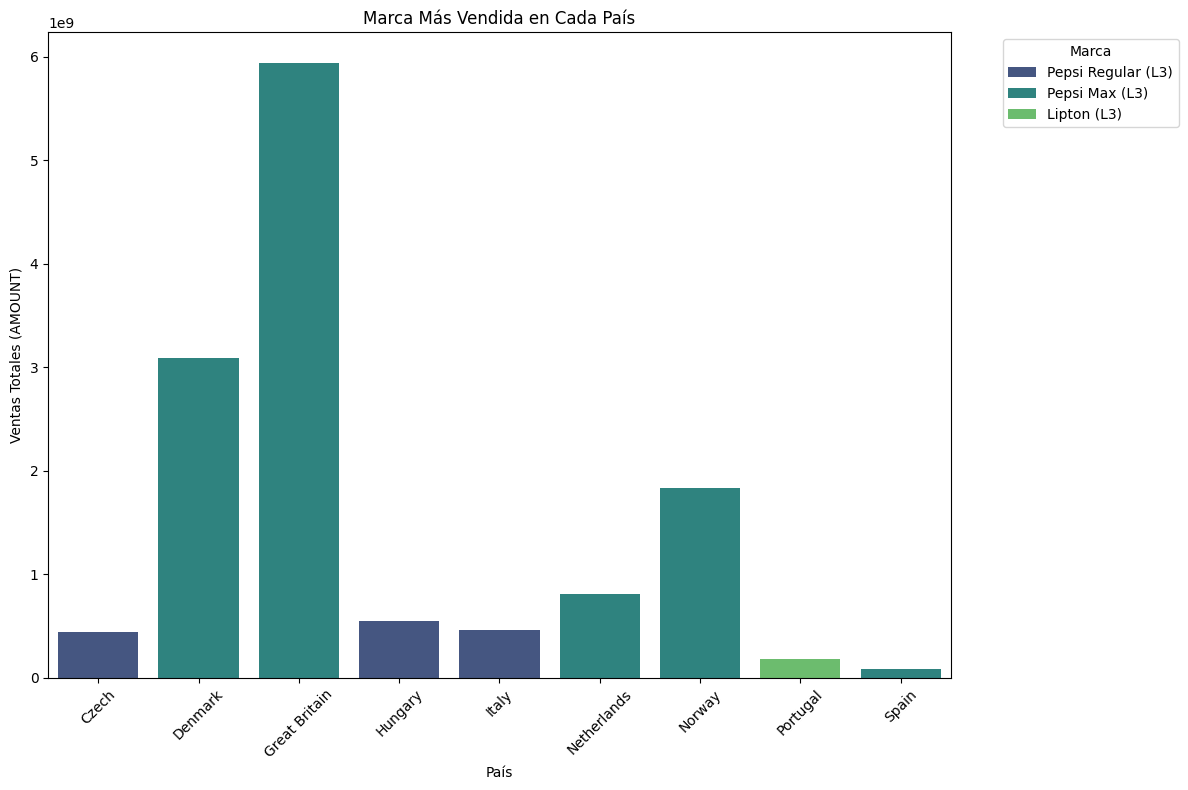

In [90]:
ventas_por_pais_y_marca = df.groupby(['COUNTRY', 'SUBBRAND'])['AMOUNT'].sum().reset_index()

ventas_por_pais_y_marca = ventas_por_pais_y_marca.sort_values(['COUNTRY', 'AMOUNT'], ascending=[True, False])

marca_mas_vendida_por_pais = ventas_por_pais_y_marca.groupby('COUNTRY').first().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=marca_mas_vendida_por_pais, x='COUNTRY', y='AMOUNT', hue='SUBBRAND', dodge=False, palette='viridis')

plt.title("Marca Más Vendida en Cada País")
plt.xlabel("País")
plt.ylabel("Ventas Totales (AMOUNT)")
plt.xticks(rotation=45)
plt.legend(title="Marca", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Vemos que Pepsi Regular, Pepsi Max y Lipton son las marcas líderes de algunos paises, y como habiamos visto anterior mente, Great Britain es el país con mayores ventas predichas.

Ahora analizaremos cuales son las marcas menos vendidas en los distintos paises.

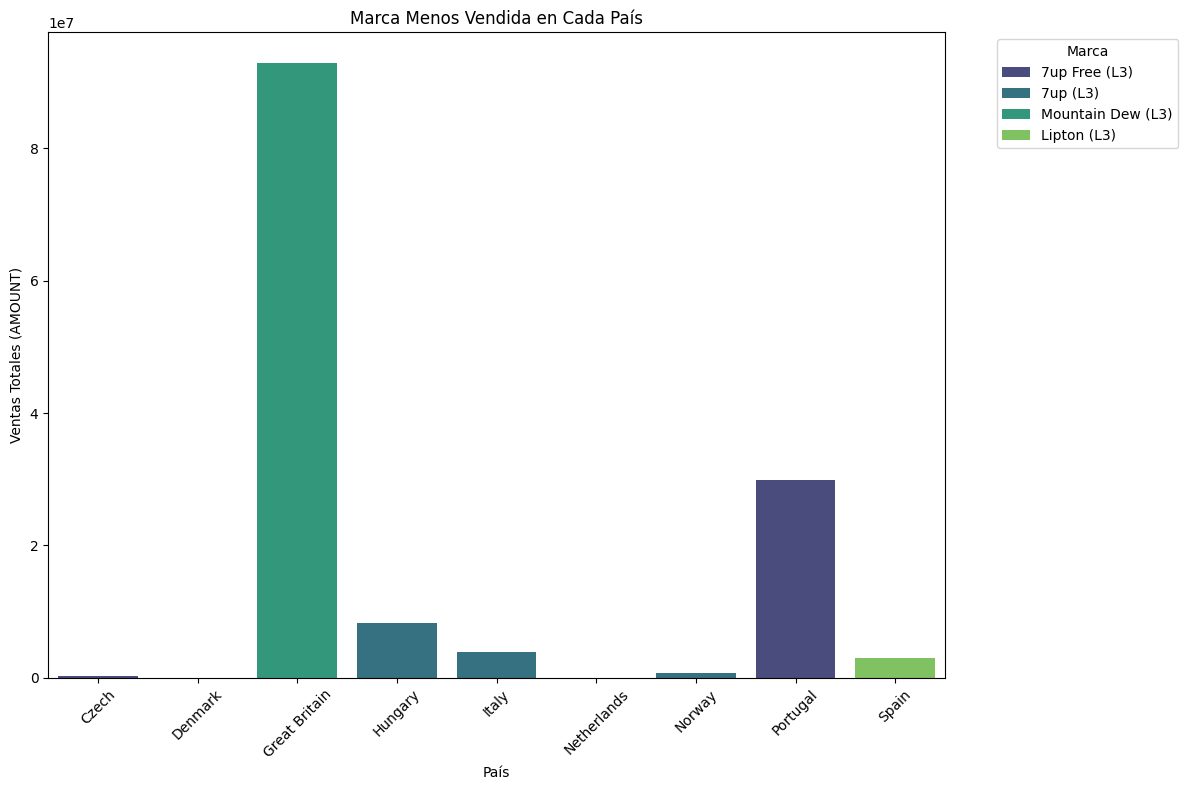

In [91]:
ventas_por_pais_y_marca = df.groupby(['COUNTRY', 'SUBBRAND'])['AMOUNT'].sum().reset_index()

ventas_por_pais_y_marca = ventas_por_pais_y_marca.sort_values(['COUNTRY', 'AMOUNT'], ascending=[True, True])

marca_menos_vendida_por_pais = ventas_por_pais_y_marca.groupby('COUNTRY').first().reset_index()


plt.figure(figsize=(12, 8))
sns.barplot(data=marca_menos_vendida_por_pais, x='COUNTRY', y='AMOUNT', hue='SUBBRAND', dodge=False, palette='viridis')

plt.title("Marca Menos Vendida en Cada País")
plt.xlabel("País")
plt.ylabel("Ventas Totales (AMOUNT)")
plt.xticks(rotation=45)
plt.legend(title="Marca", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


No podemos analizar claramente las marcas con menso ventas en Denmark y Netherlands por lo que trataremos de realizar otro gráfico con mayor claridad. Usando los mismos colores para las mismas marcas.

In [92]:
color_map = {
    '7up Free (L3)': '#2F3E75',
    '7up (L3)': '#4C78A8',
    'Mountain Dew (L3)': '#54A24B',
    'Lipton (L3)': '#82C45A'
}

marca_menos_vendida_por_pais['ISO3'] = marca_menos_vendida_por_pais['COUNTRY'].map(iso_codes)

fig = px.choropleth(
    marca_menos_vendida_por_pais,
    locations='ISO3',
    color='SUBBRAND',
    hover_name='COUNTRY',
    hover_data={'SUBBRAND': True, 'AMOUNT': True},
    scope='europe',
    color_discrete_map=color_map
)

fig.update_layout(title_text="Marca Menos Vendida en Cada País")

fig.show()

Con este mapa podemos ver claramente cuales son las marcas menos vendidas y a que país pertenecen

###Predicciones en España

A continuación analizaremos las predicciones en España. Para ello, filtraremos los datos para obtener solo los de España, separaremos las predicciones de los valores reales y para poder realizar posteriormente una comparación los uniremos en otra variable.

In [93]:
datos_espana = df[df['COUNTRY'] == 'Spain']

predicciones_espana = datos_espana[datos_espana['SCENARIO'] == 'AI_forecast']
reales_espana = datos_espana[datos_espana['SCENARIO'] == 'actual']

comparacion = pd.merge(predicciones_espana, reales_espana, on=['YEAR', 'MONTH'], suffixes=('_pred', '_real'))


Agrupamos las predicciones y los valores reales por año y mes. Crearemos dos gráficos con los distintos años 2023 y 2024.

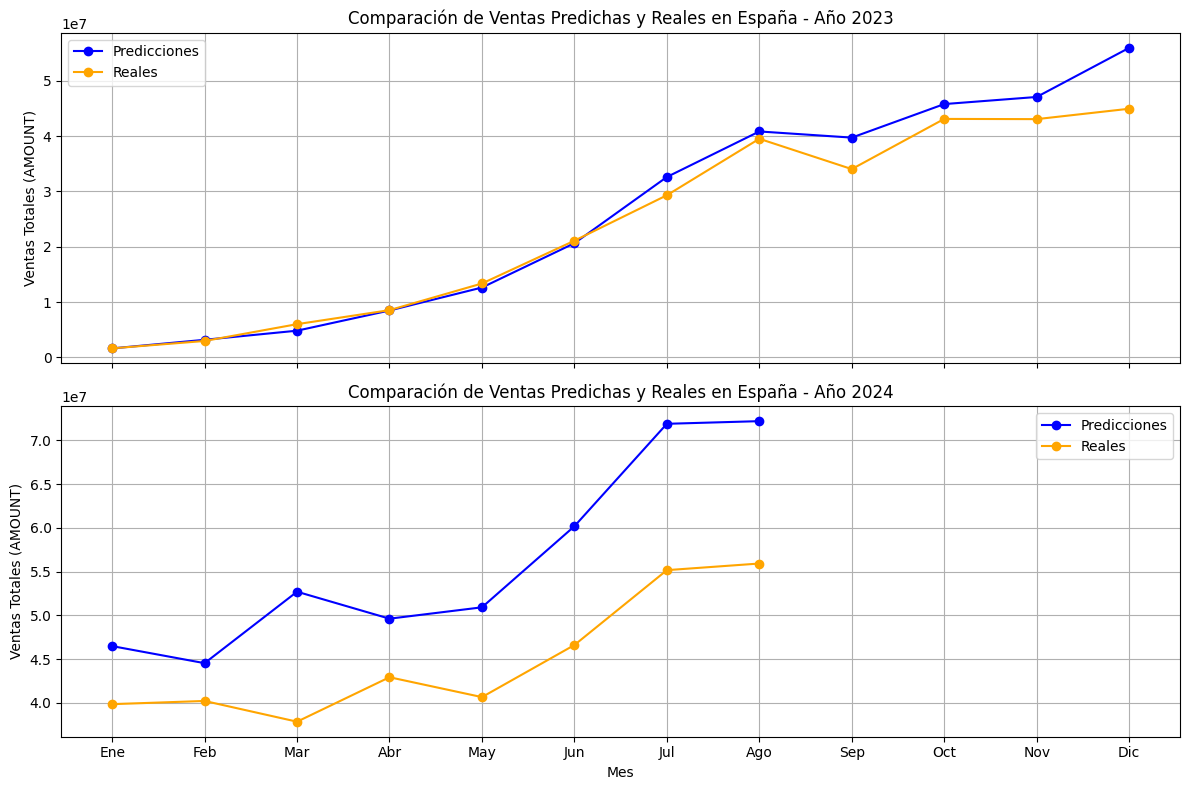

In [94]:
comparacion_agrupada = comparacion.groupby(['YEAR', 'MONTH']).agg({
    'AMOUNT_pred': 'sum',
    'AMOUNT_real': 'sum'
}).reset_index()


anios = comparacion_agrupada['YEAR'].unique()
fig, axes = plt.subplots(len(anios), 1, figsize=(12, 8), sharex=True)

for i, anio in enumerate(anios):
    # Filtrar los datos por año actual
    datos_anio = comparacion_agrupada[comparacion_agrupada['YEAR'] == anio]

    # Graficar predicciones y valores reales
    axes[i].plot(datos_anio['MONTH'], datos_anio['AMOUNT_pred'], label='Predicciones', marker='o', color='blue')
    axes[i].plot(datos_anio['MONTH'], datos_anio['AMOUNT_real'], label='Reales', marker='o', color='orange')


    axes[i].set_title(f"Comparación de Ventas Predichas y Reales en España - Año {anio}")
    axes[i].set_ylabel("Ventas Totales (AMOUNT)")
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel("Mes")
plt.xticks(range(1, 13), ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])
plt.tight_layout()
plt.show()


Podemos ver que las predicciones en el año 2023 eran bastante acertadas excepto aparir del mes de Agosto que comienzan a preveerse mayores ventas de las que habrá. Por otro lado en 2024 las predicciones no son buenas ya que estan bastante por encima con respecto a las reales.

###HORIZONTE DE PRECISION


Ahora, respecto al forecast vamos a ver cuántas veces se ha hecho una predicción específica para un país y bebida específicos. En este caso, queremos saber cuántos meses tienen predicciones para el país Portugal y la bebida Lipton (L3) bajo el tipo de pronóstico "AI_P02F".

In [95]:
pais_especifico = "Portugal"
bebida_especifica = "Lipton (L3)"

conteo_forecast = df[(df['COUNTRY'] == pais_especifico) &
                      (df['SUBBRAND'] == bebida_especifica) &
                      (df['FORECAST'] == 'AI_P02F')].shape[0]

print(f"El número de meses que he predicho para {pais_especifico} y {bebida_especifica} es: {conteo_forecast}")

El número de meses que he predicho para Portugal y Lipton (L3) es: 18


Ahora vermos en un grafico como se distribuyen las predicciones con respecto al mes y año.

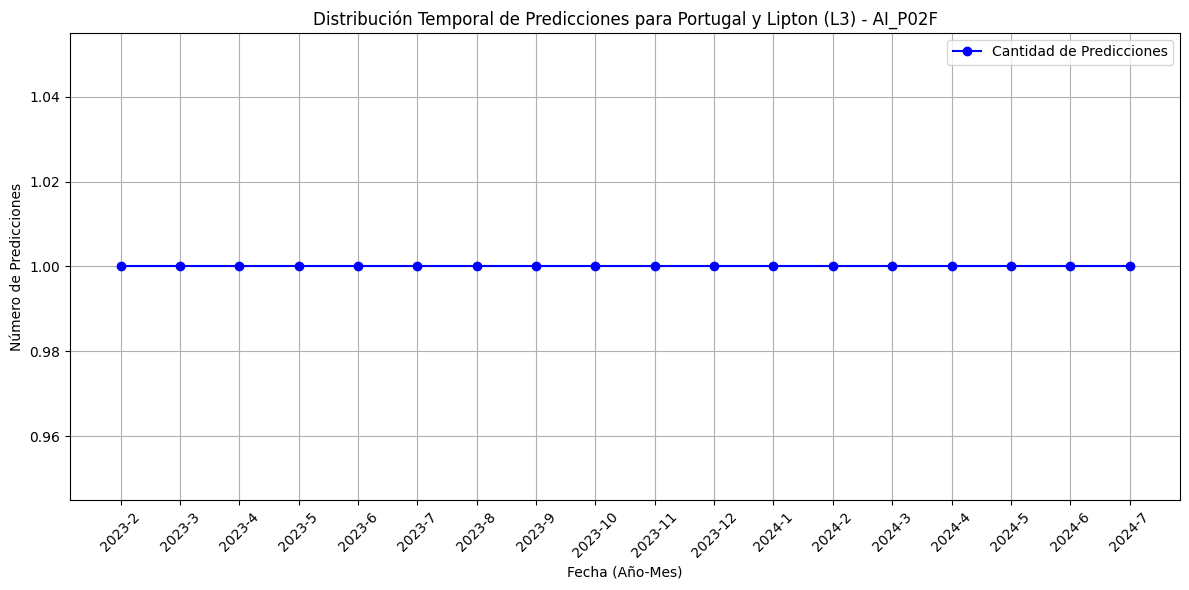

In [96]:
predicciones_por_mes = predicciones_filtradas.groupby(['YEAR', 'MONTH']).size().reset_index(name='COUNT')

predicciones_por_mes['Fecha'] = predicciones_por_mes['YEAR'].astype(str) + '-' + predicciones_por_mes['MONTH'].astype(str)

plt.figure(figsize=(12, 6))
plt.plot(predicciones_por_mes['Fecha'], predicciones_por_mes['COUNT'], marker='o', color='b', label='Cantidad de Predicciones')
plt.xlabel("Fecha (Año-Mes)")
plt.ylabel("Número de Predicciones")
plt.title(f"Distribución Temporal de Predicciones para {pais_especifico} y {bebida_especifica} - AI_P02F")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Este gráfico nos muestra en qué meses y años se realizaron las predicciones para Portugal y Lipton (L3) bajo el forecast "AI_P02F". Vemos que las predicciones son constantes y se realiza una al mes, sin embargo esto parece poco habitual por lo que vamos a comprobarlo.

In [97]:
# Verificar los datos agrupados por mes
print("Datos agrupados por mes y año:")
print(predicciones_por_mes)


Datos agrupados por mes y año:
    YEAR  MONTH  COUNT    Fecha
0   2023      2      1   2023-2
1   2023      3      1   2023-3
2   2023      4      1   2023-4
3   2023      5      1   2023-5
4   2023      6      1   2023-6
5   2023      7      1   2023-7
6   2023      8      1   2023-8
7   2023      9      1   2023-9
8   2023     10      1  2023-10
9   2023     11      1  2023-11
10  2023     12      1  2023-12
11  2024      1      1   2024-1
12  2024      2      1   2024-2
13  2024      3      1   2024-3
14  2024      4      1   2024-4
15  2024      5      1   2024-5
16  2024      6      1   2024-6
17  2024      7      1   2024-7


In [98]:
print("Datos filtrados para Portugal, Lipton (L3), y AI_P02F:")
print(predicciones_filtradas[['YEAR', 'MONTH', 'FORECAST']])


Datos filtrados para Portugal, Lipton (L3), y AI_P02F:
       YEAR  MONTH FORECAST
0      2023     12  AI_P02F
742    2023      9  AI_P02F
953    2024      5  AI_P02F
2311   2023      5  AI_P02F
3353   2024      7  AI_P02F
4945   2023      2  AI_P02F
5667   2023      8  AI_P02F
6813   2023      3  AI_P02F
7152   2023     10  AI_P02F
9619   2024      2  AI_P02F
9620   2024      4  AI_P02F
12899  2023      4  AI_P02F
13033  2024      1  AI_P02F
13887  2024      6  AI_P02F
13989  2023      7  AI_P02F
14878  2023      6  AI_P02F
18579  2023     11  AI_P02F
18664  2024      3  AI_P02F


###CUANTOS FORECAST DISTINTOS TENGO

Comprobamos cuantos FORECAST tenemos y analizamos cuales son.

In [99]:
num_forecast_distintos = df['FORECAST'].nunique()
print(f"El número de tipos de forecast distintos es: {num_forecast_distintos}")


El número de tipos de forecast distintos es: 12


In [100]:
tipos_de_forecast = df['FORECAST'].value_counts()
print("Tipos de forecast y su frecuencia:")
print(tipos_de_forecast)


Tipos de forecast y su frecuencia:
FORECAST
AI_P12F    1692
AI_P10F    1620
AI_P11F    1620
AI_P09F    1566
AI_P08F    1566
AI_P05F    1494
AI_P07F    1476
AI_P04F    1476
AI_P06F    1422
AI_P02F    1278
AI_P03F    1278
AI_PF      1278
Name: count, dtype: int64
